In [1]:
import os
import sys
import time
import torch
import random
import scipy.io
import numpy as np
from pyDOE import lhs
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from collections import OrderedDict

mpl.rcParams.update(mpl.rcParamsDefault)
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.max_open_warning'] = 4

## Global functions

In [2]:
if torch.cuda.is_available():
    """ Cuda support """
    print('cuda available')
    device = torch.device('cuda')
else:
    print('cuda not avail')
    device = torch.device('cpu')

def seed_torch(seed):
    """ Seed initialization """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_torch(2341)
torch.cuda.empty_cache()

def tonp(tensor):
    """ Torch to Numpy """
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    elif isinstance(tensor, np.ndarray):
        return tensor
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

def grad(u, x):
    """ Get grad """
    gradient = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return gradient

cuda available


## Initializations

In [3]:
# File initializations
file_path = './'
file_name = 'losses.txt'

# Exact solution boundaries
data = scipy.io.loadmat(file_path + 'AC.mat')
Exact = data['uu']
Exact0 = np.real(Exact)
t0 = data['tt'].flatten()[:,None]
x0 = data['x'].flatten()[:,None]
lbc = torch.tensor([x0.min(), t0.min()]).to(torch.float32).to(device)
ubc = torch.tensor([x0.max(), t0.max()]).to(torch.float32).to(device)
nx, nt = 256*2, 201

## DNN

In [4]:
class DNN(torch.nn.Module):
    """ DNN Class """
    
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        # Encoders
        encoder_U = torch.nn.Sequential()
        linear_layer = torch.nn.Linear(layers[0], layers[1], bias=True)
        torch.nn.init.xavier_normal_(linear_layer.weight)
        encoder_U.add_module('fc', linear_layer)
        encoder_U.add_module('act', self.activation())
        self.encoder_U = encoder_U
        encoder_V = torch.nn.Sequential()
        linear_layer = torch.nn.Linear(layers[0], layers[1], bias=True)
        torch.nn.init.xavier_normal_(linear_layer.weight)
        encoder_V.add_module('fc2', linear_layer)
        encoder_V.add_module('act2', self.activation())
        self.encoder_V = encoder_V
        
        # Layers
        layer_list = list()
        for i in range(self.depth - 1):
            w_layer = torch.nn.Linear(layers[i], layers[i+1], bias=True)
            torch.nn.init.xavier_normal_(w_layer.weight)
            layer_list.append(('layer_%d' % i, w_layer))
            layer_list.append(('activation_%d' % i, self.activation()))
        w_layer = torch.nn.Linear(layers[-2], layers[-1], bias=True)
        torch.nn.init.xavier_normal_(w_layer.weight)
        layer_list.append(('layer_%d' % (self.depth - 1), w_layer))
        layerDict = OrderedDict(layer_list)
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        U = self.encoder_U(x)
        V = self.encoder_V(x)
        for jj in range(self.depth-1):
            x = self.layers[2*jj](x)
            x = self.layers[2*jj+1](x)
            x = (1 - x) * U + x * V
        x = self.layers[-1](x)
        return x
    
class fourier(torch.nn.Module):
    """Fourier features"""

    def __init__(self, layers):
        super(fourier, self).__init__()
        
        self.L, self.M = 2.0, 10
        dim_in = 2*self.M + 2
        dim_out = 1
        layers[0] = dim_in
        model = self.dnn = DNN(layers).to(device)
        self.model = model
        # Initialize params
        for param in self.parameters():
            if len(param.shape) > 1:
                torch.nn.init.xavier_normal_(param)
        self.k = torch.nn.Parameter(torch.arange(1, self.M+1).float(), requires_grad=False)
        
    def encoding(self, x, t):
        w = 2.0*np.pi / self.L
        out = torch.hstack([torch.cos(self.k*w*x), torch.sin(self.k*w*x), t, torch.ones_like(t)]) 
        return out

    def forward(self, H):
        x = H[:, 0:1]
        t = H[:, 1:2]
        H = self.encoding(x, t)
        H = self.model(H)
        return H

## PINN

In [5]:
class PINN():
    """ PINN Class """
    
    def __init__(self, X_u, u, X_r, lb, ub, dimx, dimt, savept=None):
        
        # Initialization
        self.rba = 1  # RBA weights
        self.neum = 0 # Symmetry bc
        self.iter = 0
        self.exec_time = 0
        self.print_step = 100
        self.savept = savept
        self.dimx, self.dimt = dimx, dimt
        self.dimx_, self.dimt_ = nx, nt  # solution dim
        self.first_opt = 300000
        self.it, self.l2, self.linf = [], [], []
        self.loss, self.losses = None, []

        # Intermediate results
        self.Exact = Exact0
        X, T = np.meshgrid(x0, t0)
        X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        self.xx = torch.tensor(X_star[:, 0:1]).float().to(device)
        self.tt = torch.tensor(X_star[:, 1:2]).float().to(device)
        
        # Data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_r = torch.tensor(X_r[:, 0:1], requires_grad=True).float().to(device)
        self.t_r = torch.tensor(X_r[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.N_r = tonp(self.x_r).size
        self.N_u = dimt
        self.dnn = fourier(layers).to(device)
        
        # RBA initialization
        if self.rba == 1:
            self.rsum = 0
            self.eta = 0.001
            # note that if eta = 0.01 the rba upper bound is 10 
            # so a multiplier of 10^2 is used for the initial condition
            self.gamma = 0.999
            self.init = 1  # initialization mode (1 or 2)
            
        # Optimizer (1st ord)
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=1e-3, betas=(0.9, 0.999))
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9, verbose=True)
        self.step_size = 5000

    def net_u(self, x, t):
        """ Get the velocities """
        
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_r(self, x, t):
        """ Residual calculation """
        
        u = self.net_u(x, t)
        u_t = grad(u, t)
        u_x = grad(u, x)
        u_xx = grad(u_x, x)
        f = u_t - 0.0001*u_xx + 5.0*u*u*u - 5.0*u
        return f, u_x

    def loss_func(self):
        """ Loss function """
        
        self.optimizer.zero_grad()

        # Predictions
        self.u_pred = self.net_u(self.x_u, self.t_u)
        self.r_pred, u_x_pred = self.net_r(self.x_r, self.t_r)

        if self.rba == True:
            eta = 1 if self.init == 2 and self.iter == 0 else self.eta
            r_norm = eta*torch.abs(self.r_pred)/torch.max(torch.abs(self.r_pred))
            self.rsum = (self.rsum*self.gamma + r_norm).detach()
            loss_r = torch.mean((self.rsum*self.r_pred)**2)
            loss_u = torch.mean((self.u_pred[:self.dimx] - self.u)**2)

        else:
            loss_r = torch.mean(self.r_pred**2)
            loss_u = torch.mean((self.u_pred[:self.dimx] - self.u)**2)
        
        # Symmetry bc
        if self.neum == 1:
            loss_ub = torch.mean((self.u_pred[self.dimx:self.dimx+self.N_u] - self.u_pred[-self.N_u:])**2)
        else:
            loss_ub = 0

        # Loss calculation
        self.loss = loss_r + loss_u*100 + loss_ub
        self.loss.backward()
        self.iter += 1

        if self.iter % self.print_step == 0:
            
            with torch.no_grad():
                # Grid prediction (for relative L2)
                res = self.net_u(self.xx, self.tt)
                sol = tonp(res)
                sol = np.reshape(sol, (self.dimt_, self.dimx_)).T

                # L2 calculation
                l2_rel = np.linalg.norm(self.Exact.flatten() - sol.flatten(), 2) / np.linalg.norm(self.Exact.flatten(), 2)
                l_inf = np.linalg.norm(self.Exact.flatten() - sol.flatten(), np.inf) / np.linalg.norm(self.Exact.flatten(), np.inf)
                print('Iter %d, Loss: %.3e, Rel_L2: %.3e, L_inf: %.3e, t/iter: %.1e' % 
                     (self.iter, self.loss.item(), l2_rel, l_inf, self.exec_time))
                print()
                
                self.it.append(self.iter)
                self.l2.append(l2_rel)
                self.linf.append(l_inf)

        # Optimizer step
        self.optimizer.step()
        self.losses.append(self.loss.item())
                
    def train(self):
        """ Train model """
        
        self.dnn.train()
        for epoch in range(self.first_opt):
            start_time = time.time()
            self.loss_func()
            end_time = time.time()
            self.exec_time = end_time - start_time
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()

        # Write data
        a = np.array(self.it)
        b = np.array(self.l2)
        c = np.array(self.linf)
        # Stack them into a 2D array.
        d = np.column_stack((a, b, c))
        file = open(file_path + file_name, "w+")
        file.close()
        file = open(file_path + file_name, "w+")
        file.close()
        # Write to a txt file
        np.savetxt('losses.txt', d, fmt='%.10f %.10f %.10f')

        if self.savept != None:
            torch.save(self.dnn.state_dict(), str(self.savept)+".pt")
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1]).float().to(device)
        t = torch.tensor(X[:, 1:2]).float().to(device)
        self.dnn.eval()
        u = self.net_u(x, t)
        u = tonp(u)
        return u

## Data generation

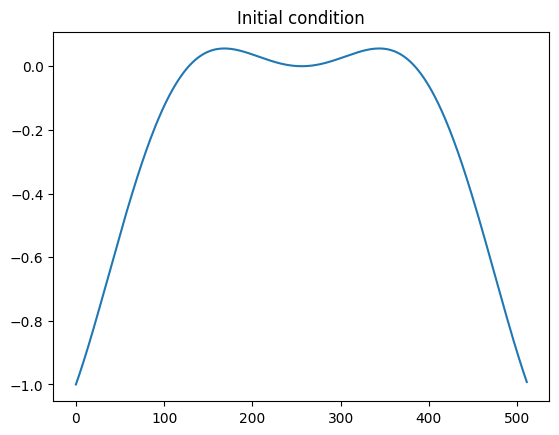

X_r shape: (25600, 2)
X_u shape: (712, 2)
u shape: (512, 1)


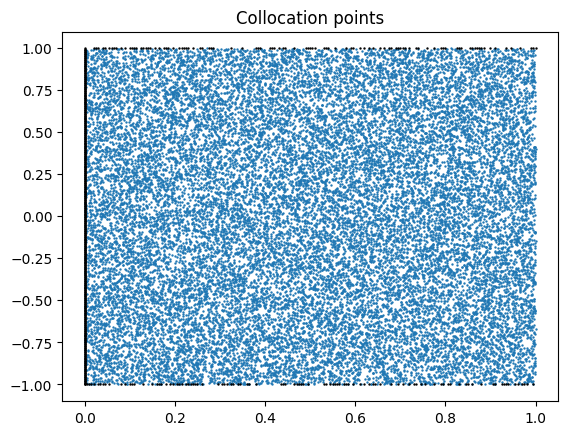

In [6]:
# Collocation points
dimx = 256*2
dimt = 201
N_u = 100
N_r = 25600
hidden = 128
layers = [2] + [hidden]*6 + [1]

# Definition
Exact = Exact0.T
tm = np.linspace(t0.min(), t0.max(), dimt)[:, None]
xm = np.linspace(x0.min(), x0.max(), dimx)[:, None]
X, T = np.meshgrid(xm, tm)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
u_train = uu1

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

plt.figure(1)
plt.title('Initial condition')
plt.plot(np.arange(uu1.shape[0]), uu1)
plt.show()

# Top/bot boundaries
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
xx3 = np.hstack((X[:,-1:], T[:,-1:]))

# Random selection
idx = np.random.choice(dimt, N_u, replace=False)
idx2 = np.random.choice(dimt, N_u, replace=False)
X_u_train = np.vstack([xx1, xx2[idx, :], xx3[idx2, :]])

# Collocation points
X_r_train = lb + (ub-lb)*lhs(2, N_r)

print('X_r shape:', X_r_train.shape)
print('X_u shape:', X_u_train.shape)
print('u shape:', u_train.shape)
            
plt.figure(2)
plt.title('Collocation points')
plt.scatter(X_r_train[:, 1], X_r_train[:, 0], s=0.5)
plt.scatter(X_u_train[:, 1], X_u_train[:, 0], s=0.5, c='k')
plt.show()

In [7]:
model = PINN(X_u_train, u_train, X_r_train, lb, ub, dimx, dimt=N_u, savept='weights')

Adjusting learning rate of group 0 to 1.0000e-03.


## Training

In [8]:
%%time
model.train()

Iter 100, Loss: 1.274e-01, Rel_L2: 7.188e-01, L_inf: 1.368e+00, t/iter: 5.8e-02

Iter 200, Loss: 1.864e-01, Rel_L2: 6.713e-01, L_inf: 1.363e+00, t/iter: 5.8e-02

Iter 300, Loss: 1.052e-01, Rel_L2: 6.206e-01, L_inf: 1.159e+00, t/iter: 5.8e-02

Iter 400, Loss: 3.898e-02, Rel_L2: 5.895e-01, L_inf: 1.127e+00, t/iter: 5.8e-02

Iter 500, Loss: 2.333e-02, Rel_L2: 5.625e-01, L_inf: 1.162e+00, t/iter: 5.8e-02

Iter 600, Loss: 1.742e-02, Rel_L2: 5.381e-01, L_inf: 1.102e+00, t/iter: 5.8e-02

Iter 700, Loss: 1.737e-02, Rel_L2: 5.225e-01, L_inf: 1.052e+00, t/iter: 5.9e-02

Iter 800, Loss: 2.127e-02, Rel_L2: 5.093e-01, L_inf: 1.051e+00, t/iter: 5.8e-02

Iter 900, Loss: 2.357e-02, Rel_L2: 5.014e-01, L_inf: 1.037e+00, t/iter: 5.8e-02

Iter 1000, Loss: 3.582e-02, Rel_L2: 4.967e-01, L_inf: 1.021e+00, t/iter: 5.8e-02

Iter 1100, Loss: 4.477e-02, Rel_L2: 4.787e-01, L_inf: 9.992e-01, t/iter: 5.8e-02

Iter 1200, Loss: 3.424e-02, Rel_L2: 4.548e-01, L_inf: 9.772e-01, t/iter: 5.8e-02

Iter 1300, Loss: 8.789e-0

In [ ]:
# Prediction
Exact = Exact0
X, T = np.meshgrid(x0, t0)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred = model.predict(X_star)
U_pred = np.reshape(u_pred, (Exact.shape[1], Exact.shape[0])).T
l2_rel = np.linalg.norm(Exact.flatten() - U_pred.flatten()) / np.linalg.norm(Exact.flatten(), 2)
print('L2:', l2_rel)

plt.figure(1)
plt.title('Abs Error u')
plt.xlabel('t')
plt.ylabel('x')
plt.imshow(np.abs(Exact-U_pred), aspect='auto', cmap='rainbow')
plt.colorbar()
plt.show()